# 前処理

**※説明の読みやすさのために，警告を非表示にします．実際のプログラムでは警告の表示を推奨します．**

In [1]:
# 警告の表示を停止
import warnings
warnings.filterwarnings('ignore')
# Transformersのログを非表示
from transformers import logging
logging.set_verbosity_error()

データセットを用いてモデルを学習する前に，モデルの期待する入力形式に変換する前処理を行う必要があります．
データがテキスト，画像，またはオーディオであるかどうかに関わらず，それらはテンソルのバッチに変換する必要があります．
Hugging Face Transformers は，データをモデル用に準備するのに役立つ前処理クラスのセットを提供しています．

## 自然言語処理（Natural Language Processing）

テキストデータの前処理に使用するツールは，トークナイザです．
トークナイザは，ルールにしたがってテキストを*トークン*に分割します．
トークンは数値に変換されたあと，さらにテンソルに変換され，モデルの入力となります．
モデルが必要とする追加の入力は，トークナイザによって追加されます．

> 事前学習済みのモデルを使用する場合，紐づけられた事前学習済みトークナイザを使用する必要があります．
> これにより，テキストが事前学習コーパスと同じ方法で分割され，事前学習中に通常`vocab`として参照される対応するトークンインデックスを使用することができます．

`AutoTokenizer.from_pretrained()`メソッドを使用して，事前学習済みのトークナイザを読み込みます:

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

次に，テキストをトークナイザに渡します．

In [3]:
encoded_input = tokenizer("Hello, I'm a single sentence!")
print(encoded_input)

{'input_ids': [101, 8667, 117, 146, 112, 182, 170, 1423, 5650, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


トークナイザは，重要な3つの項目を持つ辞書を返します．

- `input_ids`: 文中の各トークンに対応するインデックス
- `attention_mask`: 各トークンがアテンションを受けるべきかどうかを示すバイナリマスク
- `token_type_ids`: 複数のシーケンスがある場合，トークンがどのシーケンスに属するかを示すトークンタイプ

`input_ids`をデコードして元のテキストを取得することもできます．

In [4]:
tokenizer.decode(encoded_input["input_ids"])

"[CLS] Hello, I'm a single sentence! [SEP]"

デコード結果を見て分かるように，トークナイザは文章に2つの特別なトークン，`CLS`（クラシファイア）と`SEP`（セパレータ）を追加します．
すべてのモデルが特別なトークンを必要とするわけではありませんが，必要な場合，トークナイザが自動的にそれらを追加します．

複数の文を前処理する場合，トークナイザにリストとして渡します:

In [5]:
batch_sentences = ["Hello I'm a single sentence",
                   "And another sentence",
                   "And the very very last one"]
encoded_inputs = tokenizer(batch_sentences)

from pprint import pprint
pprint(encoded_inputs)


{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101, 8667, 146, 112, 182, 170, 1423, 5650, 102],
               [101, 1262, 1330, 5650, 102],
               [101, 1262, 1103, 1304, 1304, 1314, 1141, 102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0]]}


### Pad

複数の文章を扱うとき，それらの長さは異なることが多いです．
テンソル（モデルの入力）では均一な形状（均一な長さ）である必要があるため問題になります．
パディング（padding）は，短い文にパディングトークンと呼ばれる特殊なトークンを追加して，テンソルを最も長い文の長さに合わせる処理です．

バッチ内の短いシーケンスを最長のシーケンスに合わせるため，`padding`パラメータを`True`に設定します:

In [6]:
batch_sentences = ["Hello I'm a single sentence",
                   "And another sentence",
                   "And the very very last one"]
encoded_inputs = tokenizer(batch_sentences, padding=True)

pprint(encoded_inputs)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 0]],
 'input_ids': [[101, 8667, 146, 112, 182, 170, 1423, 5650, 102],
               [101, 1262, 1330, 5650, 102, 0, 0, 0, 0],
               [101, 1262, 1103, 1304, 1304, 1314, 1141, 102, 0]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]]}


2番目と3番目の文は，最長の文に合わせるために0がパディングされています．

### Truncation

モデルが処理するのに長すぎるシーケンスが与えられた場合，シーケンスを切り詰める（truncate）ことができます．

モデルが処理できる最大のシーケンス長にするためには，`truncation`パラメータを`True`に設定します:

In [7]:
batch_sentences = ["Hello I'm a single sentence",
                    "And another sentence",
                    "And the very very last one"]
encoded_inputs = tokenizer(batch_sentences, padding=True, truncation=True)
pprint(encoded_inputs)                   

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 0]],
 'input_ids': [[101, 8667, 146, 112, 182, 170, 1423, 5650, 102],
               [101, 1262, 1330, 5650, 102, 0, 0, 0, 0],
               [101, 1262, 1103, 1304, 1304, 1314, 1141, 102, 0]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]]}


### テンソルの生成

最後に，モデルに直接渡すために，トークナイザがテンソルを出力するように設定します．

`return_tensors`パラメータを`'pt'`に設定すると，PyTorchテンソルが返されます:

In [8]:
batch_sentences = ["Hello I'm a single sentence",
                   "And another sentence",
                   "And the very very last one",]
encoded_inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
pprint(encoded_inputs)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0]]),
 'input_ids': tensor([[ 101, 8667,  146,  112,  182,  170, 1423, 5650,  102],
        [ 101, 1262, 1330, 5650,  102,    0,    0,    0,    0],
        [ 101, 1262, 1103, 1304, 1304, 1314, 1141,  102,    0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])}


## 音（Audio）

オーディオタスクの場合，データセットをモデル用に準備するために特徴抽出器が必要です．
特徴抽出器は，生のオーディオデータから特徴を抽出し，それらをテンソルに変換するために設計されています．

`PolyAI/minds14`データをロードして，オーディオデータセットで特徴抽出器がどのように使用できるか確認しましょう:

In [9]:
from datasets import load_dataset, Audio
dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")

`audio`列の最初の要素を確認します．
`audio`列を呼び出すと，自動的にオーディオファイルが読み込まれ，リサンプリングされます．

In [10]:
dataset[0]["audio"]

{'path': '/home/fujie/.cache/huggingface/datasets/downloads/extracted/727c238ff56827207fa183e263914211df387082d5c9e015991ad43c9cc5ab82/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
         0.        ,  0.        ]),
 'sampling_rate': 8000}

3つの要素が得られます:
- `array`は読み込まれた音声信号で，1次元の配列です．必要に応じてリサンプリングされることもあります．
- `path`は音声ファイルの場所を表します．
- `sampling_rate`はサンプリング周波数（Hz）です．

このチュートリアルでは`Wav2Vec2`モデルを使用します．
モデルカードを確認すると，このモデルは16kHzのサンプリングされた音声で事前学習されていることがわかります．

今回読み込んだデータセットのサンプリング周波数は8kHzであることが確認されていますので，リサンプリングする必要があります．

1. Hugging Face Datasets の`cast_column`メソッドを使用して，サンプリングレートを16kHzにします:

In [11]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))

2. 再度`audio`列を呼び出して，リサンプリングされたオーディオデータを確認します:

In [12]:
dataset[0]["audio"]

{'path': '/home/fujie/.cache/huggingface/datasets/downloads/extracted/727c238ff56827207fa183e263914211df387082d5c9e015991ad43c9cc5ab82/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 1.70562416e-05,  2.18727451e-04,  2.28099874e-04, ...,
         3.43842403e-05, -5.96364771e-06, -1.76846661e-05]),
 'sampling_rate': 16000}

次に，入力を正規化しパディングするために特徴抽出器をロードします．
テキストデータのパディングと同様，オーディオデータも0を追加します（これは無音と解釈されます）．

`AutoFeatureExtractor.from_pretrained()`を使用して特徴抽出器をロードします:

In [13]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

データの`audio` -> `array` を特徴抽出器に渡します．

オーディオの特長抽出時に頻繁に発生する問題を回避するため，`sampling_rate`を指定することを推奨します．

In [14]:
audio_input = [dataset[0]["audio"]["array"]]
feature_extractor(audio_input, sampling_rate=16_000)

{'input_values': [array([ 3.0293269e-04,  2.7676334e-03,  2.8821775e-03, ...,
        5.1470479e-04,  2.1597825e-05, -1.2164921e-04], dtype=float32)]}

トークナイザと同様に，バッチ内の可変長シーケンスを処理するためにパディングや切り詰めを行うことができます．
試してみましょう:

In [15]:
print(dataset[0]["audio"]["array"].shape)
print(dataset[1]["audio"]["array"].shape)

(173398,)
(106496,)


次に示す関数`preprocess_function`は，データセットを前処理してオーディオのサンプル数を揃えます．
最大サンプル長を指定し，特長抽出器はシーケンスをそれに合わせてパディングするか切り詰めます．

In [16]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(audio_arrays, 
                               sampling_rate=16_000,
                               padding=True,
                               max_length=100_000,
                               truncation=True,
    )
    return inputs

`preprocess_function`を使用してデータセット（今回は最初の5つ）を前処理します:

In [17]:
processed_dataset = preprocess_function(dataset[:5])

長さが揃っていることがわかります．

In [18]:
print(processed_dataset["input_values"][0].shape)
print(processed_dataset["input_values"][1].shape)

(100000,)
(100000,)


## 視覚情報処理（Computer Vision） 

コンピュータビジョンタスクでは，データセットに対してモデル入力用に準備するための画像処理が必要です．
画像の前処理には，モデルが期待する入力形式に変換するためのいくつかのステップが含まれています．
これらのステップには，リサイズ，正規化，カラーチャネルの補正，およびテンソルへの変換などが含まれています．

> 画像の前処理は通常，データ拡張と組み合わせて行われます．画像の前処理とデータ拡張は両方とも画像データを変換しますが，目的が異なります:
> - データ拡張は，過学習を防ぎ，モデルの堅牢性を向上させるのに役立つ方法で画像を変更します．拡張する方法はさまざまなものがあります．明るさや色の調整，クロップ（切り取り），回転，リサイズ，ズームなどです．
> - 画像の前処理は，画像がモデルの期待する形式と一致することを保証します．コンピュータモデルをファインチューニングする場合，モデルが最初に学習されたときとまったく同じ方法で前処理をする必要があります．
> データ拡張には任意のライブラリを使えます．画像の前処理にはモデルに関連づけられた`ImageProcessor`を使用します．

コンピュータビジョンのデータセットで画像処理を使用する方法を示すために，`food101`データセットをロードします．

> データセットがかなり大きいため，Hugging Face Datasetsの`split`パラメータを使用して，トレーニングデータの小さなサンプルのみをロードします．

In [19]:
from datasets import load_dataset
dataset = load_dataset("food101", split="train[:100]")

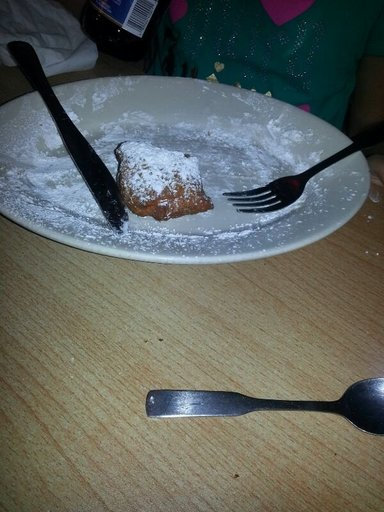

In [20]:
dataset[0]["image"]

`AutoImageProcessor`をロードします:

In [21]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

1. まず，データの拡張を行ってみましょう．任意のライブラリを利用できますが，ここでは`torchvision`の`transforms`モジュールを使用します．
   
   `Compose`を使用して，`RandomResizedCrop`と`ColorJitter`を組み合わせます．

In [22]:
from torchvision.transforms import RandomResizedCrop, ColorJitter, Compose

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ColorJitter(brightness=0.5, hue=0.5)])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
_transforms

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.5, 1.5), contrast=None, saturation=None, hue=(-0.5, 0.5))
)

2. モデルは`pixel_values`を入力として受け取ります．
   `ImageProcessor`は，画像の正規化とテンセルの生成を行います．
   一連の画像に対するデータ拡張と画像前処理を組み合わせて，`pixel_values`を生成する関数を作成します．

In [24]:
def transforms(examples):
    images = [_transforms(img.convert("RGB")) for img in examples["image"]]
    examples["pixel_values"] = image_processor(images, do_resize=False, return_tensors="pt")["pixel_values"]
    return examples

3. 次に Hugging Face Datasets の`set_transform`を使用して，変換をリアルタイムで適用します:

In [25]:
dataset.set_transform(transforms)

4. 画像にアクセスすると，画像処理が`pixel_values`を追加したことがわかります．これで処理済みのデータセットをモデルに渡すことができます．

In [26]:
dataset[0].keys()

dict_keys(['image', 'label', 'pixel_values'])

表示をしてみると，画像がランダムに切り抜かれ，色が変更されていることがわかります．

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].


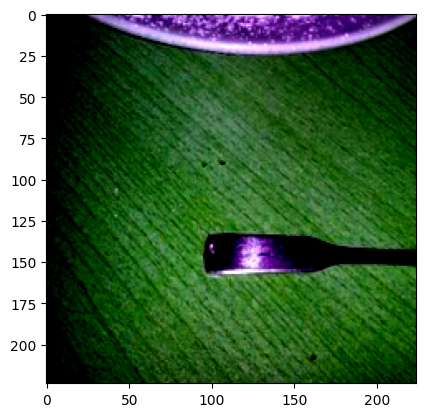

In [27]:
import numpy as np
import matplotlib.pyplot as plt

img = dataset[0]["pixel_values"]
plt.imshow(img.permute(1, 2, 0))

### Pad

`DETR`（物体検出器の一種）をファインチューニングする場合，モデルは学習時にスケールの変更を適用します．
これにより，バッチ内の画像のサイズが異なる場合があります．
`DetrImageProcessor`から`DetrImageProcessor.pad()`を使用して，カスタムの`collate_fn`を定義して画像を一緒にバッチ処理できます．

In [28]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [items["label"] for items in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]    
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## マルチモーダル（Multi Modal）

マルチモーダル入力を使用するタスクの場合，データを準備するためのプロセッサが必要です．
プロセッサは，例えばトークナイザや特徴量抽出器などの2つの処理オブジェクトを結合します．

音声認識（ASR）のためのプロセッサの使用例を見るために，LJSpeechデータセットをロードします．

In [29]:
from datasets import load_dataset

lj_speech = load_dataset("lj_speech", split="train")

ASRの場合，主に`audio`と`text`を扱うため，他の列を削除します:

In [30]:
ls_speech = lj_speech.map(remove_columns=["file", "id", "normalized_text"])

`audio`と`text`の列を見てみましょう．

In [31]:
ls_speech[0]["audio"]

{'path': 'LJ001-0001.wav',
 'array': array([-7.32421875e-04, -7.62939453e-04, -6.40869141e-04, ...,
         7.32421875e-04,  2.13623047e-04,  6.10351562e-05]),
 'sampling_rate': 22050}

In [32]:
ls_speech[0]["text"]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

モデルの事前学習時のデータに合わせるために，サンプリングレートを変換します:

In [33]:
ls_speech = ls_speech.cast_column("audio", Audio(sampling_rate=16_000))

プロセッサをロードします:

In [34]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")

1. `array`に含まれるオーディオデータを`input_values`に変換し，`text`をトークン化して`labels`に変換する関数を作成します．

In [35]:
def prepare_dataset(example):
    audio = example["audio"]
    example.update(processor(audio=audio["array"], text=example["text"], sampling_rate=16_000))
    return example

2. サンプルに`prepare_dataset`関数を適用します．

In [36]:
prepare_dataset(ls_speech[0])

{'audio': {'path': 'LJ001-0001.wav',
  'array': array([-0.00061751, -0.00074496, -0.00068972, ...,  0.00068615,
          0.00013802,  0.        ]),
  'sampling_rate': 16000},
 'text': 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 'input_values': [array([-6.4672441e-03, -7.7975024e-03, -7.2209686e-03, ...,
          7.1398341e-03,  1.4186004e-03, -2.1961636e-05], dtype=float32)],
 'labels': [23,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
 